# Rosenblatt transformation

In this exercise, we will get introduced to sampling from correlated (dependent) variables using the Rosenblatt transformation. 

We consider 3 variables: wind speed $u$, turbulence $\sigma_u$, and wind shear exponent $\alpha$. The turbulence is considered conditionally dependent on the wind speed with distribution parameters: 
$\mu_(\sigma_u) (u)=I_{ref} (0.75u+3.8); \sigma_{\sigma_u} = 2.8 I_{ref} $ ; (Lognormal)

where $I_{ref} = 0.14$ is a constant;

and the wind shear explonent is also considered conditionally dependent on the wind speed:
$\mu_\alpha (u)=0.088(log⁡(u)−1); \sigma_{\alpha} (u)=1/u $; (Normal)



Our task is to generate a random sample (a "Monte Carlo simulation") of correlated wind speed, turbulence and wind shear realizations using the Rosenblatt transformation.

In [32]:
# Helper functions - normal distribution

# Normal distribution
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y


# Helper functions - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

In [33]:
import numpy as np
import scipy.stats as stats

# Define functions (inline functions for conditional distribution parameters)

Iref = 0.14; 

#--> for shear alpha
MuAlphaFunc = lambda u: 0.088*(np.log(u) - 1) #takes u, yields mu_alpha
SigmaAlphaFunc = lambda u: 1/u

#--> for turbulence sigma
MuSigmaFunc = lambda u: Iref*(0.75*u + 3.8)
SigmaSigmaU = 2.8*Iref

# Set up a Monte Carlo simulation using a Rosenblatt transformation

#-->params for monte carlo
N = 10000 # nsamples
Fu = np.random.rand(N) 

#-->params for Weibull distribution of U
Aweib = 11.28
Kweib = 2
u = stats.weibull_min.ppf(Fu,c = Kweib,scale = Aweib) # uses the weibull function to yield a large number of data

# calculate params for other 2 distributions, mu and sigma each
muSigma = MuSigmaFunc(u)
sigmaSigma = SigmaSigmaU*np.ones(muSigma.shape)

Fsigma = np.random.rand(N) # create new random sample
sigmaU = LogNormDist(2,Fsigma,muSigma,sigmaSigma) #draw monte carlo samples from distibution

muAlpha = MuAlphaFunc(u)
sigmaAlpha = SigmaAlphaFunc(u)
Falpha = np.random.rand(N)
alpha = NormalDist(2,Falpha,muAlpha,sigmaAlpha)



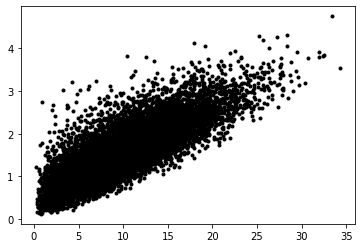

In [34]:
# Plot - wind speed vs. turbulence
import matplotlib.pyplot as plt
plt.plot(u,sigmaU,'.k')
plt.show()

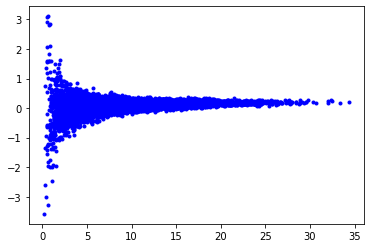

In [35]:
# Plot wind speed vs. wind shear
plt.plot(u,alpha,'.b')
plt.show()

In [36]:
###--------------- Tasks:

#1 Calibrate a simplified (surrogate) model of the extreme load function which maps the dependence
#  between the loads and the environmental conditions

#2 Devise a procedure which can determine the expected value of the blade root extreme load, as
#  function of a given joint distribution of wind speed, turbulence and wind shear

#3 Estimate what is the uncertainty in the estimated expected value of the extreme load - e.g. due to
#  model uncertainty and realization-to-realization uncertainty

#####------------ Structure and to dos 

#1 Set up programs needed to generate random samples (a Monte Carlo sample) from the joint
#  distribution of the environmental conditions. The dependence between variables is taken into
#  account using a Rosenblatt transformation
#-------> already given

#2 Run a crude Monte-Carlo simulation to obtain a reference for the expected value of the function.

#3 Choose the type(s) of surrogate models you want to calibrate – and select an appropriate
#  experimental design (e.g. a grid or just a crude Monte Carlo) to generate your training dataset.

#4 Calibrate the surrogate model(s) of your choice

#5 Evaluate the model performance and adequacy. Make e.g. one-to-one plots of true outputs vs.
#  model predictions, make a residual analysis (plot residuals vs. variables), calculate error terms (e.g.
#  r-square, RMS error, MAE) to evaluate the quality of the model fit and estimate model uncertainty

#6 Run a numerical simulation with the surrogate model to determine the expected value of the
#  function and compare with the results of the Monte Carlo

In [37]:
### To do 2: run crude monte carlo simualation,
#aim: use created wind data, to obtain an estimate of the loads.

#1 import function
import _utils as ut
#2 create input for function, as specified in the assignment
winddata = np.transpose(np.array([u,sigmaU,alpha]))
#2 plug wind data in function
loads = ut.MysteriousLoadFunc(winddata)
# have a look at the output
#3 calculate statistics for the loads



In [41]:
loads_mean = np.mean(loads)
loads_std = np.std(loads)
print(f"Mean of loads: {loads_mean} \t Std of loads: {loads_std} \n \
     These are only approximate values for this realisation of the Monte Carlo samples!")

Mean of loads: 63214.12820150735 	 Std of loads: 8039.773450899044 
      These are only approximate values for this realisation of the Monte Carlo samples!


Text(0.5, 1.0, 'Loads over alpha')

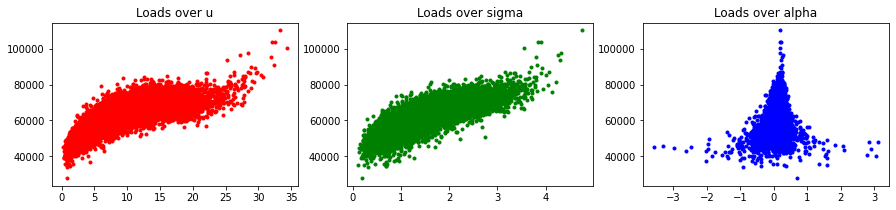

In [58]:
# lets have a look at the data
fig, axs = plt.subplots(1,3,figsize=[15,3])
axs[0].plot(winddata[:,0],loads,'.r')
axs[0].set_title("Loads over u")
axs[1].plot(winddata[:,1],loads,'.g')
axs[1].set_title("Loads over sigma")
axs[2].plot(winddata[:,2],loads,'.b')
axs[2].set_title("Loads over alpha")

In [43]:
###--------> 3 Choose the type(s) of surrogate models you want to calibrate – and select an appropriate
#            experimental design (e.g. a grid or just a crude Monte Carlo) to generate your training dataset.
